In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
from sklearn.cluster import KMeans
import seaborn.objects as so
from statsmodels.stats import proportion

/Group16T/common/chenh2/miniconda3/envs/ml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-19 18:29:04.695072: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 18:29:04.698494: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 18:29:04.733699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-19 18:29:04.733720: E external/local_xla/xla/stream_executor/c

In [2]:
#all, TNKI, THM, YCTKP, TCN, HT
# load data
file_path = "/Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_all.csv"

df = pd.read_csv(file_path)

file_path = "/Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_all_65+yr.csv"
temp = pd.read_csv(file_path)
temp = temp.dropna().reset_index(drop=True)
df['rate65']= temp["rate"]

file_path = "/Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_all_50-64yr.csv"
temp = pd.read_csv(file_path)
temp = temp.dropna().reset_index(drop=True)
#y50_64 = temp["rate"].values
df['rate50_64']= temp["rate"]

file_path = "/Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_all_30-49yr.csv"
#file_path = "/Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_all_30-49yr.csv"
temp = pd.read_csv(file_path)
temp = temp.dropna().reset_index(drop=True)
#y30_49 = temp["rate"].values
df['rate30_49']= temp["rate"]

#group = file_path.split("\\")[-1].replace(".csv", "")

# === 移除 NaN ===
df = df.dropna().reset_index(drop=True)

# === 特徵與目標 ===
drop_cols = ["day", "Count_all", "Count_cvd", "rate", "rate65",'rate50_64','rate30_49']
features = [col for col in df.columns if col not in drop_cols]
features = features[73:] # ONLY INCLUDE air polution data
#features = features[:73] # EXCLUDE air polution data
X = df[features].values
y = df["rate"].values
y65 = df["rate65"].values
y50_64 = df["rate50_64"].values
y30_49 = df["rate30_49"].values
#y = df["Count_cvd"].values

In [3]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
reducer = umap.UMAP(random_state=5)
#reducer = umap.UMAP(random_state=40)
embedding = reducer.fit_transform(X_scaled)
embedding.shape

/Group16T/common/chenh2/miniconda3/envs/ml_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(8369, 2)

In [5]:
y_pred = KMeans(n_clusters=2,n_init=100,random_state=30).fit_predict(X_scaled)
#df['cluster']=np.char.mod('%d', y_pred)

df['cluster_raw'] = y_pred

# Determine which cluster is smaller
cluster_counts = df['cluster_raw'].value_counts().to_dict()
small_cluster = min(cluster_counts, key=cluster_counts.get)

# Remap: smaller cluster → 0, larger → 1
df['cluster'] = df['cluster_raw'].apply(lambda x: 0 if x == small_cluster else 1)

# Convert to string (e.g., 'Cluster_0' / 'Cluster_1')
df['cluster_str'] = df['cluster'].astype(str)

#status_mapping = {0: '0', 1: '1',}
#df['cluster'] = df['cluster'].map(status_mapping)

In [6]:
df['cluster'].value_counts()

cluster
1    5654
0    2715
Name: count, dtype: int64

In [7]:
df['cluster_str'].value_counts()

cluster_str
1    5654
0    2715
Name: count, dtype: int64

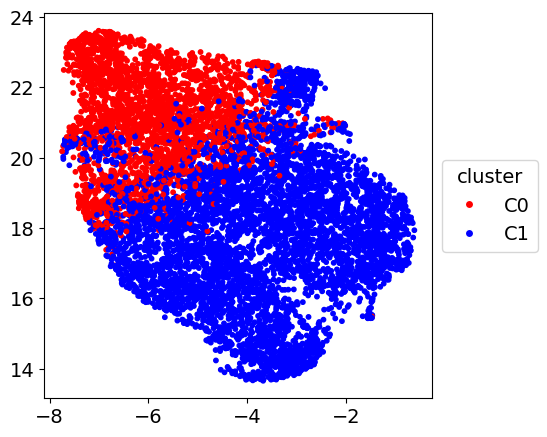

In [8]:
#colors = ['red' if label == 0 else 'blue' for label in y_pred]
plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 14}) 
scat = plt.scatter(embedding[:,0], embedding[:,1], c=df['cluster'], s=10, cmap='bwr_r')
#scat = plt.scatter(embedding[:,0], embedding[:,1], c=df['cluster'], s=10, cmap='bwr_r')

# Create custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='C0', markerfacecolor='red', markersize=6),
    plt.Line2D([0], [0], marker='o', color='w', label='C1', markerfacecolor='blue', markersize=6)
]
plt.legend(handles=handles, title='cluster',loc='center left',bbox_to_anchor=(1.0, 0.5))

In [9]:
target_y = y65
threshold = np.mean(target_y)
#using chi2 to test the proportion of high CVD (> average counts) byetween two kmeans clusters
cvd_risk = []
for n in target_y:
    if n > threshold:
        cvd_risk.append('high')
    else:
        cvd_risk.append('low')
df['cvd_risk'] = cvd_risk

Chi-square statistic: 910.3000354584645
p-value: 5.658884859680792e-200


/tmp/ipykernel_1407501/2461966734.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = [a[0], a[2]]


<Figure size 600x500 with 0 Axes>

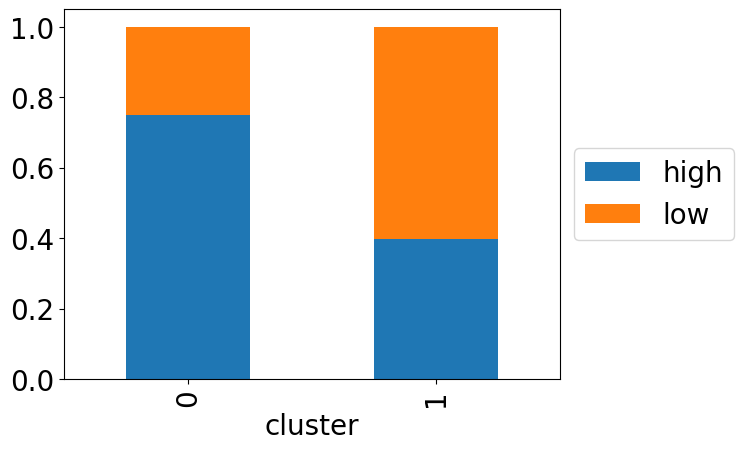

In [10]:
plt.figure(figsize=(6, 5))
plt.rcParams.update({'font.size': 20}) 

#https://stackoverflow.com/questions/43074199/how-to-plot-stacked-normalized-histograms
# Count all entries for all scores and all categories
a = df.groupby([df['cluster_str'], 'cvd_risk']).size() 
# Normalize
b = df.groupby(df['cluster_str'])['cvd_risk'].count()
df_a = a.div(b, axis=0,level=0)
# Plot
df_a.unstack().plot.bar(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

count = [a[0], a[2]]
nobs = [b['0'], b['1']]

statistic, pval, table = proportion.proportions_chisquare(count, nobs)

plt.xlabel('cluster')
print("Chi-square statistic:", statistic)
print("p-value:", pval)

In [11]:
count_air = count
nobs_air =nobs

In [13]:
#df.iloc[:, 73:].columns.tolist()

In [14]:
#all, TNKI, THM, YCTKP, TCN, HT
# load data
file_path = "/Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_all.csv"

df = pd.read_csv(file_path)

file_path = "/Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_all_65+yr.csv"
temp = pd.read_csv(file_path)
temp = temp.dropna().reset_index(drop=True)
df['rate65']= temp["rate"]

file_path = "/Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_all_50-64yr.csv"
temp = pd.read_csv(file_path)
temp = temp.dropna().reset_index(drop=True)
#y50_64 = temp["rate"].values
df['rate50_64']= temp["rate"]

file_path = "/Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_all_30-49yr.csv"
#file_path = "/Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_all_30-49yr.csv"
temp = pd.read_csv(file_path)
temp = temp.dropna().reset_index(drop=True)
#y30_49 = temp["rate"].values
df['rate30_49']= temp["rate"]

#group = file_path.split("\\")[-1].replace(".csv", "")

# === 移除 NaN ===
df = df.dropna().reset_index(drop=True)

# === 特徵與目標 ===
drop_cols = ["day", "Count_all", "Count_cvd", "rate", "rate65",'rate50_64','rate30_49']
features = [col for col in df.columns if col not in drop_cols]
#features = features[73:] # ONLY INCLUDE air polution data
features = features[:73] # EXCLUDE air polution data
X = df[features].values
y = df["rate"].values
y65 = df["rate65"].values
y50_64 = df["rate50_64"].values
y30_49 = df["rate30_49"].values
#y = df["Count_cvd"].values

In [15]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
reducer = umap.UMAP(random_state=5)
#reducer = umap.UMAP(random_state=40)
embedding = reducer.fit_transform(X_scaled)
embedding.shape

/Group16T/common/chenh2/miniconda3/envs/ml_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(8369, 2)

In [17]:
y_pred = KMeans(n_clusters=2,n_init=100,random_state=30).fit_predict(X_scaled)
#df['cluster']=np.char.mod('%d', y_pred)

df['cluster_raw'] = y_pred

# Determine which cluster is smaller
cluster_counts = df['cluster_raw'].value_counts().to_dict()
small_cluster = min(cluster_counts, key=cluster_counts.get)

# Remap: smaller cluster → 0, larger → 1
df['cluster'] = df['cluster_raw'].apply(lambda x: 0 if x == small_cluster else 1)

# Convert to string (e.g., 'Cluster_0' / 'Cluster_1')
df['cluster_str'] = df['cluster'].astype(str)

#status_mapping = {0: '0', 1: '1',}
#df['cluster'] = df['cluster'].map(status_mapping)

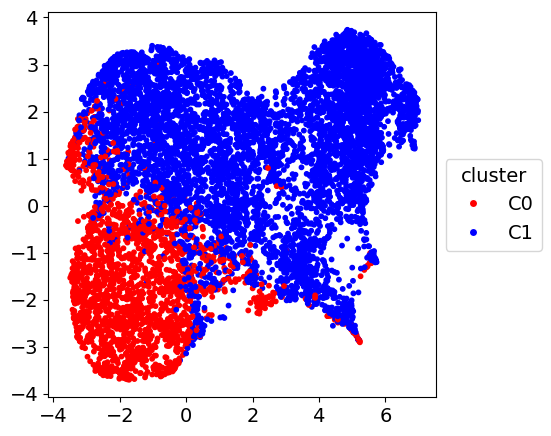

In [18]:
#colors = ['red' if label == 0 else 'blue' for label in y_pred]
plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 14}) 
scat = plt.scatter(embedding[:,0], embedding[:,1], c=df['cluster'], s=10, cmap='bwr_r')
#scat = plt.scatter(embedding[:,0], embedding[:,1], c=df['cluster'], s=10, cmap='bwr_r')

# Create custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='C0', markerfacecolor='red', markersize=6),
    plt.Line2D([0], [0], marker='o', color='w', label='C1', markerfacecolor='blue', markersize=6)
]
plt.legend(handles=handles, title='cluster',loc='center left',bbox_to_anchor=(1.0, 0.5))

In [19]:
target_y = y65
threshold = np.mean(target_y)
#using chi2 to test the proportion of high CVD (> average counts) byetween two kmeans clusters
cvd_risk = []
for n in target_y:
    if n > threshold:
        cvd_risk.append('high')
    else:
        cvd_risk.append('low')
df['cvd_risk'] = cvd_risk

Chi-square statistic: 179.58255944066303
p-value: 5.978126469405039e-41


/tmp/ipykernel_1407501/2461966734.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = [a[0], a[2]]


<Figure size 600x500 with 0 Axes>

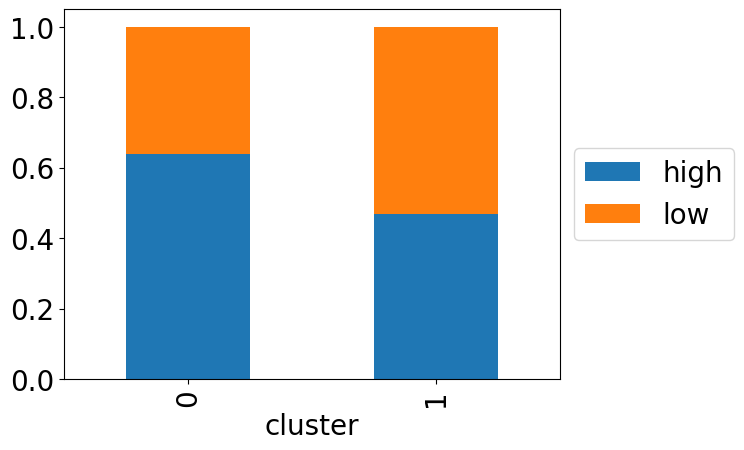

In [20]:
plt.figure(figsize=(6, 5))
plt.rcParams.update({'font.size': 20}) 

#https://stackoverflow.com/questions/43074199/how-to-plot-stacked-normalized-histograms
# Count all entries for all scores and all categories
a = df.groupby([df['cluster_str'], 'cvd_risk']).size() 
# Normalize
b = df.groupby(df['cluster_str'])['cvd_risk'].count()
df_a = a.div(b, axis=0,level=0)
# Plot
df_a.unstack().plot.bar(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

count = [a[0], a[2]]
nobs = [b['0'], b['1']]

statistic, pval, table = proportion.proportions_chisquare(count, nobs)

plt.xlabel('cluster')
print("Chi-square statistic:", statistic)
print("p-value:", pval)

In [21]:
count_weather = count
nobs_weather =nobs

In [23]:
nobs_weather

[2102, 6267]

In [22]:
count_weather

[1342, 2943]

In [24]:
count_high = [count_air[0], count_weather[0]]

In [26]:
nobs_high = [nobs_air[0], nobs_weather[0]]

In [30]:
count_high

[2036, 1342]

In [31]:
nobs_high

[2715, 2102]

In [36]:
statistic, pval, table = proportion.proportions_chisquare(count_high, nobs_high)

print("Chi-square statistic:", statistic)
print("p-value:", pval)

Chi-square statistic: 70.26868097764029
p-value: 5.17528558176753e-17
